In [16]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Computer vision model

In [17]:
import torch
from torchvision import datasets, models, transforms
from torch import nn, optim
from os import listdir
from os.path import join, isfile
from PIL import Image
import pandas as pd
import os

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the dataset
data_dir = "data\PNG"
class_names = ['BENIGN', 'MALIGNANT']  # Replace with your class names

# Create a dictionary to map class names to integers
class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

# Create a custom dataset class to load the images from the directories
class CancerDataset(torch.utils.data.Dataset):
    def __init__(self,csv_file,transform):
        self.df = pd.read_csv(csv_file)
        self.df = self.df[['pathology', 'cropped image file path']]
        self.pathology = self.df['pathology'].values
        self.labels = [1 if label == 'MALIGNANT' else 0 for label in self.pathology]
        self.transform = transform

        self.new = self.df['cropped image file path'].apply(lambda x: x.split('/')[2])
        self.df['cropped image file path (full)'] = self.new.apply(lambda x: "data\\jpeg\\" + x)
        available_folders = listdir("data\\jpeg\\")
        self.folder_paths = self.df['cropped image file path (full)'].values
        self.file_paths = [join(folder_path, listdir(folder_path)[0]) for folder_path in self.folder_paths if folder_path.split('\\')[-1] in available_folders]
        self.labels = [label for label, folder_path in zip(self.labels,self.folder_paths) if folder_path.split('\\')[-1] in available_folders]
        
    def __getitem__(self, index):
        label = self.labels[index]
        image = Image.open(self.file_paths[index]).convert('RGB')
        image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)
    
    

# set up a basic transform set that just converts from numpy/opencv format to torch, and then resizes appropriatly
plain_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        ])

training_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        ])

# create the dataset object given your csv and transform we just set up
dataset = CancerDataset("data\csv\calc_case_description.csv",plain_transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])



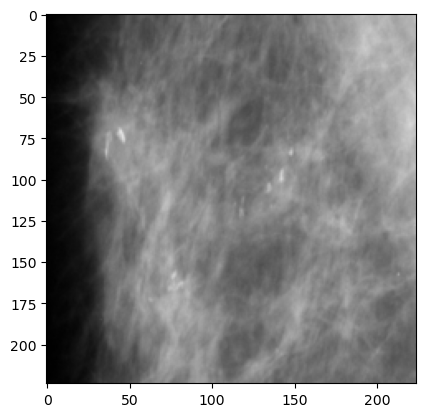

In [18]:
import matplotlib.pyplot as plt
import numpy as np
image, label = dataset.__getitem__(np.random.randint(dataset.__len__()))
plt.imshow(image.numpy().transpose(1,2,0))

In [19]:
from torch.utils.data import WeightedRandomSampler

# get target labes of all samples
targets = [sample[1] for sample in train_dataset]
# count num of samples in each class
class_counts=[targets.count(i) for i in range(len(class_names))]
num_samples = sum(class_counts)
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights_train = [class_weights[targets[i]] for i in range(int(num_samples))]

# Create data loaders
sampler_train = WeightedRandomSampler(torch.DoubleTensor(weights_train), int(num_samples))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False, sampler = sampler_train)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load a pre-trained model (ResNet-50)
model = models.resnet50(pretrained=True)

# Freeze the model's parameters
# for param in model.parameters():
#     param.requires_grad = False
    #? change this to True to allow the model to be trainable
    #? will finetune resnet18, not just the last layer

# Replace the last layer of the model with a new classifier
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#? smaller learning rate, less pull between batches
#? 0.001 is TOO BIG 
optimizer = optim.Adam(model.parameters(), lr=0.0004)

print(len(train_loader))
print(len(train_dataset))

b:\LHL\LHL-Final\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
b:\LHL\LHL-Final\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


47
1496


model training

In [20]:
from sklearn.metrics import classification_report
# Train the model
num_epochs = 10
running_loss_history = []
val_loss_history = []
true_positives = {class_name: 0 for class_name in class_names}
false_positives = {class_name: 0 for class_name in class_names}
false_negatives = {class_name: 0 for class_name in class_names}
predicted_labels = []
true_labels = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = training_transform(inputs)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    running_loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validate the model
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            #! run outputs through softmax instead ^ for roc
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_accuracy = correct / total

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    model.train()
    # Forward pass
    # outputs = model(inputs)
    # loss = criterion(outputs, labels)

    # Backward pass and optimization
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    #Update TP, FP, and FN for each class
    _, predicted = torch.max(outputs.data, 1)
    for i in range(len(labels)):
        true_label = class_names[labels[i]]
        predicted_label = class_names[predicted[i]]

        if true_label == predicted_label:
            true_positives[true_label] += 1
        elif predicted_label != 'normal':
            false_positives[predicted_label] += 1
        else:
            false_negatives[true_label] += 1

# Generate the classification report
predicted_labels = [class_names[label] for label in predicted_labels]
true_labels = [class_names[label] for label in true_labels]

report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

# Save the trained model
torch.save(model.state_dict(), "resnet50_classifier_model.pth")

Epoch 1/10, Loss: 0.6110
Validation Loss: 0.6642, Accuracy: 0.6320
Epoch 2/10, Loss: 0.5756
Validation Loss: 0.6531, Accuracy: 0.6293
Epoch 3/10, Loss: 0.5596
Validation Loss: 0.5317, Accuracy: 0.6693
Epoch 4/10, Loss: 0.5454
Validation Loss: 0.5966, Accuracy: 0.6427
Epoch 5/10, Loss: 0.5168
Validation Loss: 0.5598, Accuracy: 0.6907
Epoch 6/10, Loss: 0.5318
Validation Loss: 0.6113, Accuracy: 0.6667
Epoch 7/10, Loss: 0.5024
Validation Loss: 1.0464, Accuracy: 0.5893
Epoch 8/10, Loss: 0.4834
Validation Loss: 0.6284, Accuracy: 0.6827
Epoch 9/10, Loss: 0.4960
Validation Loss: 0.6999, Accuracy: 0.6480
Epoch 10/10, Loss: 0.4526
Validation Loss: 0.6109, Accuracy: 0.6747
              precision    recall  f1-score   support

      BENIGN       0.68      0.68      0.68       140
   MALIGNANT       0.51      0.51      0.51        90

    accuracy                           0.61       230
   macro avg       0.59      0.59      0.59       230
weighted avg       0.61      0.61      0.61       230



In [21]:
# #! save this for future use
# from sklearn.metrics import f1_score
# # Define the hyperparameter grid
# learning_rates = [0.001, 0.0001, 0.00001]
# batch_sizes = [16, 32, 64] 
# #! don't do batch size
# #! don't do hyperparameters

# # Initialize the best F1 score and corresponding hyperparameters
# best_f1_score = 0
# best_hyperparameters = None

# # Iterate over the hyperparameter grid
# for lr in learning_rates:
#     for batch_size in batch_sizes:
#         # Create data loaders for training and validation sets
#         train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#         val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#         # Load the pre-trained ResNet-18 model
#         model = models.resnet18(pretrained=True)
#         num_features = model.fc.in_features
#         model.fc = nn.Linear(num_features, 2)  # Replace the last layer with a linear layer for binary classification

#         # Move the model to the device
#         model.to(device)

#         # Define the loss function and optimizer
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(model.parameters(), lr=lr)

#         # Train the model
#         model.train()
#         for epoch in range, num_epochs:  # You can adjust the number of epochs
#             for inputs, labels in train_loader:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # Forward pass
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 # Backward pass and optimization
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#         # Evaluate the model on the validation set
#         model.eval()
#         with torch.no_grad():
#             val_loss = 0.0
#             correct = 0
#             total = 0
#             predicted_labels = []
#             true_labels = []
#             for inputs, labels in val_loader:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # Forward pass
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 val_loss += loss.item() * inputs.size(0)

#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#                 predicted_labels.extend(predicted.tolist())
#                 true_labels.extend(labels.tolist())

#             val_loss = val_loss / len(val_loader.dataset)
#             val_accuracy = correct / total
#             val_f1_score = f1_score(true_labels, predicted_labels, average='weighted')

#             # Update the best F1 score and corresponding hyperparameters
#             if val_f1_score > best_f1_score:
#                 best_f1_score = val_f1_score
#                 best_hyperparameters = {'Learning Rate': lr, 'Batch Size': batch_size}

# # Print the best hyperparameters and corresponding F1 score
# print("Best Hyperparameters:")
# print(best_hyperparameters)
# print("Best F1 Score:", best_f1_score)

training metrics

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Set the device for evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Create a list to store the predicted labels and true labels
predicted_labels = []
true_labels = []

# Iterate over the validation dataset and make predictions
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

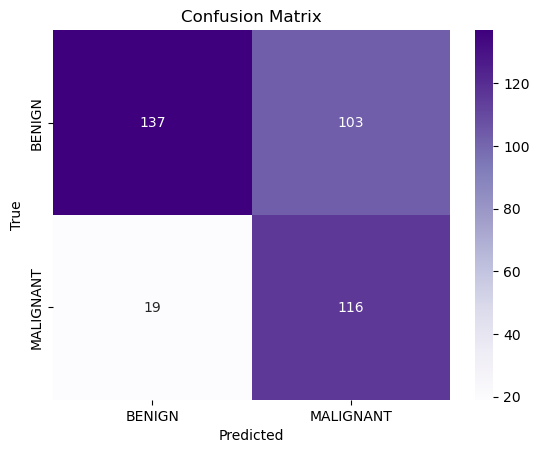

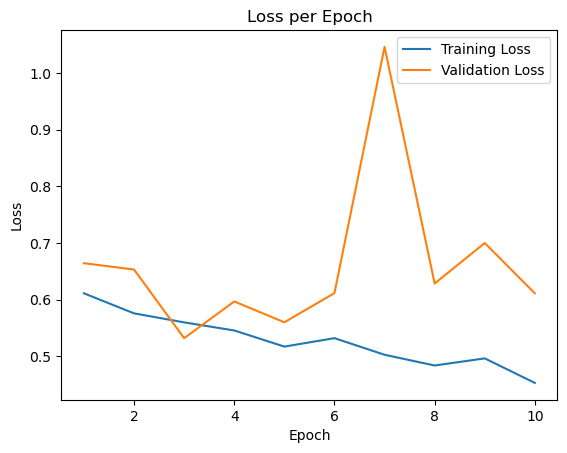

In [30]:



# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Graph the loss per epoch
loss_values = [epoch_loss for epoch_loss in running_loss_history]
val_loss_values = [val_loss for val_loss in val_loss_history]

epochs = range(1, num_epochs + 1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

Hyperparameter tuning

In [25]:
# #! save this for later use
# import torch
# from torchvision import datasets, models, transforms
# from torch import nn, optim
# from sklearn.metrics import f1_score
# import pandas as pd

# # Set the device for training
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define the image transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize the images to 224x224
#     transforms.ToTensor(),  # Convert the images to PyTorch tensors
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the images
# ])

# # Load the dataset
# data_dir = "data\PNG"
# class_names = ['normal', 'cancer']  # Replace with your class names

# # Create a dictionary to map class names to integers
# class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

# # Create a custom dataset class to load the images from the directories
# class CancerDataset(torch.utils.data.Dataset):
#     def __init__(self, csv_file, transform):
#         df = pd.read_csv(csv_file)
#         df = df[['pathology', 'image file path']]
#         pathology = df['pathology'].values
#         self.labels = [1 if label == 'MALIGNANT' else 0 for label in pathology]
#         self.transform = transform

#         new = df['image file path'].str.split('/', n=3, expand=False)
#         new = new.apply(lambda x: x[2])
#         df['image file path'] = "data/jpeg/" + new[2]
#         folder_paths = df['image file path'].values
#         self.file_paths = [join(folder_path, listdir(folder_path)[0]) for folder_path in folder_paths]
    
#     def __getitem__(self, index):
#         label = self.labels[index]
#         image = Image.open(self.file_paths[index]).convert('RGB')
#         image = self.transform(image)
#         return image, label
    
#     def __len__(self):
#         return len(self.labels)

# # Create the dataset object
# dataset = CancerDataset("data\csv\calc_case_description.csv", transform)

# # Split the dataset into training and validation sets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# # Define the hyperparameter grid
# learning_rates = [0.001, 0.0001, 0.00001]
# batch_sizes = [16, 32, 64]

# # Initialize the best F1 score and corresponding hyperparameters
# best_f1_score = 0
# best_hyperparameters = None

# # Iterate over the hyperparameter grid
# for lr in learning_rates:
#     for batch_size in batch_sizes:
#         # Create data loaders for training and validation sets
#         train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#         val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#         # Load the pre-trained ResNet-18 model
#         model = models.resnet18(pretrained=True)
#         num_features = model.fc.in_features
#         model.fc = nn.Linear(num_features, 2)  # Replace the last layer with a linear layer for binary classification

#         # Move the model to the device
#         model.to(device)

#         # Define the loss function and optimizer
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(model.parameters(), lr=lr)

#         # Train the model
#         model.train()
#         for epoch in range(10):  # You can adjust the number of epochs
#             for inputs, labels in train_loader:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # Forward pass
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 # Backward pass and optimization
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#         # Evaluate the model on the validation set
#         model.eval()
#         with torch.no_grad():
#             val_loss = 0.0
#             correct = 0
#             total = 0
#             predicted_labels = []
#             true_labels = []
#             for inputs, labels in val_loader:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # Forward pass
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 val_loss += loss.item() * inputs.size(0)

#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#                 predicted_labels.extend(predicted.tolist())
#                 true_labels.extend(labels.tolist())

#             val_loss = val_loss / len(val_loader.dataset)
#             val_accuracy = correct / total
#             val_f1_score = f1_score(true_labels, predicted_labels, average='weighted')

#             # Update the best F1 score and corresponding hyperparameters
#             if val_f1_score > best_f1_score:
#                 best_f1_score = val_f1_score
#                 best_hyperparameters = {'Learning Rate': lr, 'Batch Size': batch_size}

# # Print the best hyperparameters and corresponding F1 score
# print("Best Hyperparameters:")
# print(best_hyperparameters)
# print("Best F1 Score:", best_f1_score)

# multi-class classification

In [26]:
import pandas as pd
df = pd.read_pickle("data\df.pkl")

In [27]:
from sklearn.preprocessing import LabelEncoder
def encode_categorical_columns(df, categorical_columns):
    encoders = {}

    for column in categorical_columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        encoders[column] = le

    return df, encoders

In [28]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report



# Encode the target variable
le = LabelEncoder()
target = le.fit_transform(df['pathology'])


categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
df, encoders = encode_categorical_columns(df, categorical_columns)

# Select the features you want to use for prediction
features = df.drop(columns=['pathology'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

      BENIGN       0.68      0.90      0.77       142
   MALIGNANT       0.85      0.56      0.68       140

    accuracy                           0.73       282
   macro avg       0.76      0.73      0.73       282
weighted avg       0.76      0.73      0.73       282



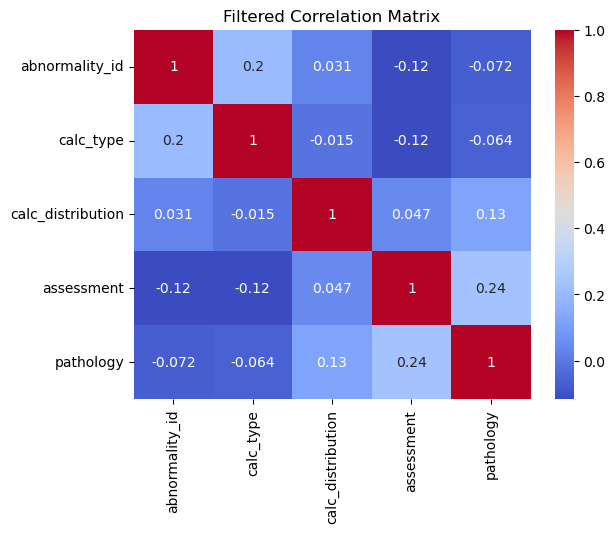

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df.corr()
# Get the correlation values with the target variable
corr_with_target = corr_matrix['pathology']
# Filter the features with correlation greater than 0.5
filtered_features = corr_with_target[abs(corr_with_target) > 0.05].index.tolist()

# Create a new correlation matrix with the filtered features
filtered_corr_matrix = corr_matrix.loc[filtered_features, filtered_features]

# Plot the correlation matrix
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm')
plt.title("Filtered Correlation Matrix")
plt.show()